<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Выводы-по-результатам-анализа:" data-toc-modified-id="Выводы-по-результатам-анализа:-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Выводы по результатам анализа:</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейна-регрессия" data-toc-modified-id="Линейна-регрессия-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейна регрессия</a></span></li><li><span><a href="#Модель-CatBoost" data-toc-modified-id="Модель-CatBoost-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Модель CatBoost</a></span></li><li><span><a href="#Выводы-по-результатам-обучения-моделей:" data-toc-modified-id="Выводы-по-результатам-обучения-моделей:-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Выводы по результатам обучения моделей:</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Выводы-по-итогам-тестирования:" data-toc-modified-id="Выводы-по-итогам-тестирования:-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Выводы по итогам тестирования:</a></span></li></ul></li><li><span><a href="#Итоговый-вывод:" data-toc-modified-id="Итоговый-вывод:-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Итоговый вывод:</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [7]:
#Импортируем необходимые библиотеки
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    make_scorer
)
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt 
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import TimeSeriesSplit
import os
from datetime import datetime

In [8]:
# Загрузим данные:

pth1_df = '/datasets/taxi.csv'
pth2_df = 'taxi.csv'

if os.path.exists(pth1_df):
    df = pd.read_csv(pth1_df, index_col=[0], parse_dates=[0])
elif os.path.exists(pth2_df):
    df = pd.read_csv(pth2_df, index_col=[0], parse_dates=[0])
else:
    print('Something is wrong')

In [9]:
# Посмотрим информацию о ДатаФрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [10]:
# Проверим хронолический порядок
print(df.index.is_monotonic)

True


C:\Users\ipd08\AppData\Local\Temp\ipykernel_25232\596060479.py:2: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  print(df.index.is_monotonic)


In [11]:
df.isnull().sum()

num_orders    0
dtype: int64

In [12]:
# Посмотрим на первые 7 строк
df.head(24)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [13]:
# Посмотрим на последние строки
df.tail()

,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


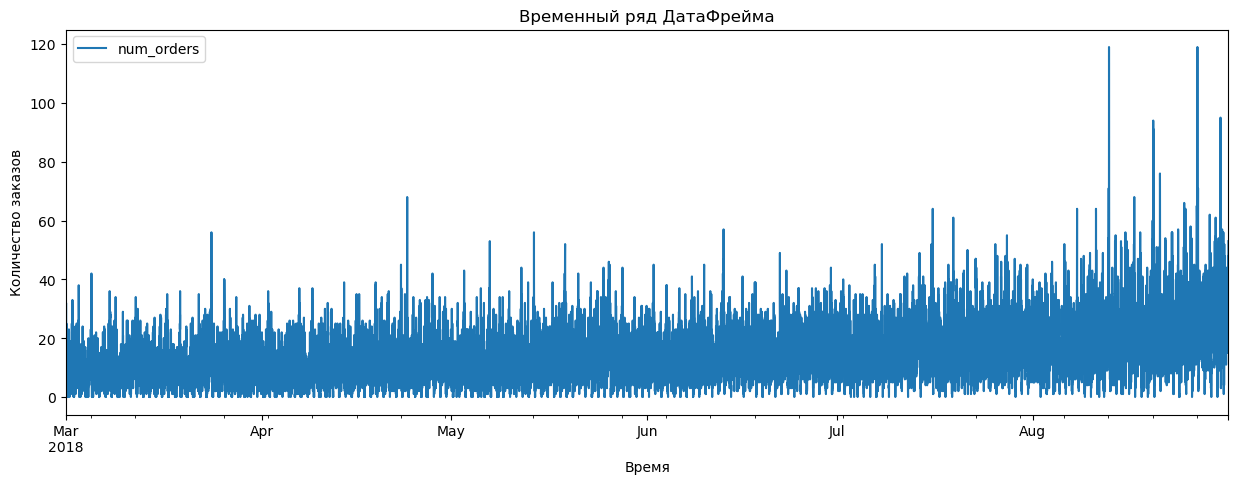

In [14]:
# Построим диаграмму временного ряда
plt.rcParams ['figure.figsize'] = [15, 5]
df.plot()
plt.title('Временный ряд ДатаФрейма')
plt.xlabel("Время")
plt.ylabel("Количество заказов");


In [15]:
# Сделаем ресемплинг на 1 час с суммированием
df = df.resample('1H').sum()

In [16]:
# Посмотрим на результат
df.head(24)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


## Анализ

In [17]:
# Разложим временной ряд на тренд, созонность и остатки
decomposed = seasonal_decompose(df)

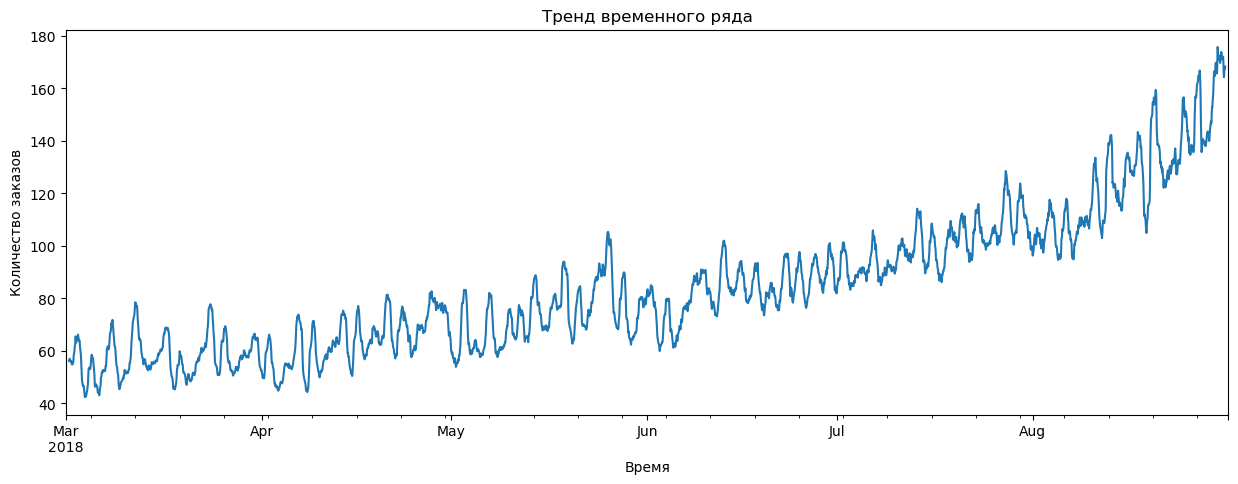

<Figure size 1500x500 with 0 Axes>

In [18]:
# Линия тренда
decomposed.trend.plot()
plt.title('Тренд временного ряда')
plt.xlabel("Время")
plt.ylabel("Количество заказов")
plt.figure();

Если предположить, что данные о заказах взяты из Российского рынка. То в 2018 году сервис Яндекс Такси увеличил свою вырочку почти в 5 раз. Кроме того, в этом году был большой поток туристов из-за ЧМ мира по футболу. По итогам года все агрегаторы такси увеличили свою вырочку.

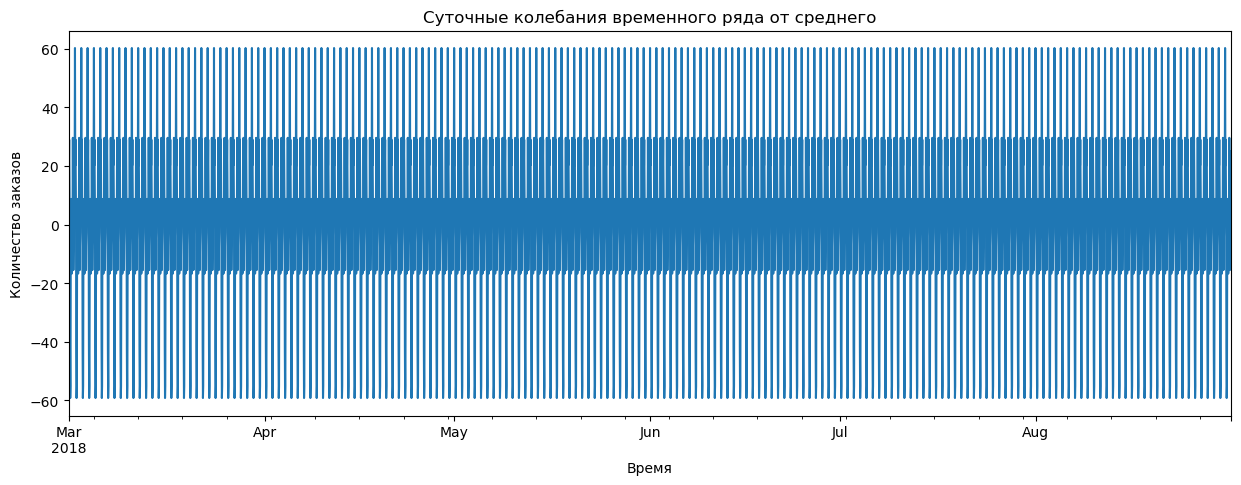

<Figure size 1500x500 with 0 Axes>

In [19]:
# Сезонность
decomposed.seasonal.plot()
plt.title('Суточные колебания временного ряда от среднего')
plt.xlabel("Время")
plt.ylabel("Количество заказов")
plt.figure();

Сезонность показывает колебания количества заказов в течение исследуемого промежутка времени.т.е. суточные колебания количества заказов. Падение количсетва заказов с 00 часов до 6 утра, бурный рост к обеду, потом опять затухание до конца рабочего дня и опять рост до конца дня.

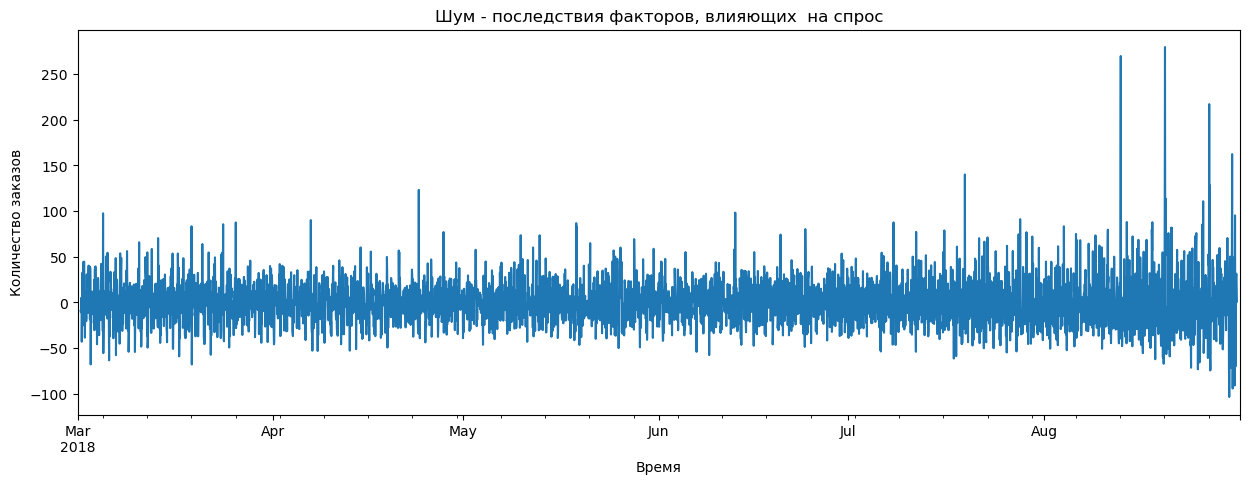

<Figure size 1500x500 with 0 Axes>

In [20]:
# Мусор - или важные особенности дня , то что система не может понять.
decomposed.resid.plot()
plt.title('Шум - последствия факторов, влияющих  на спрос')
plt.xlabel("Время")
plt.ylabel("Количество заказов")
plt.figure();

In [21]:
# Добавим среднее скользящее
df['rolling_mean'] = df.rolling(24).mean()

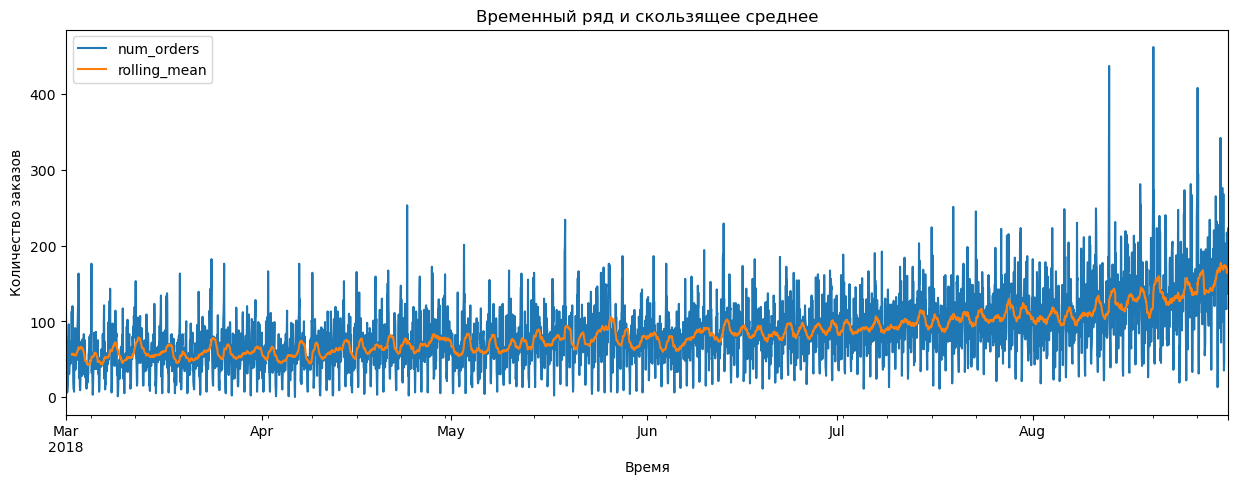

<Figure size 1500x500 with 0 Axes>

In [22]:
# Изменение среднего значения во времени
df.plot()
plt.title('Временный ряд и скользящее среднее')
plt.xlabel("Время")
plt.ylabel("Количество заказов")
plt.figure();

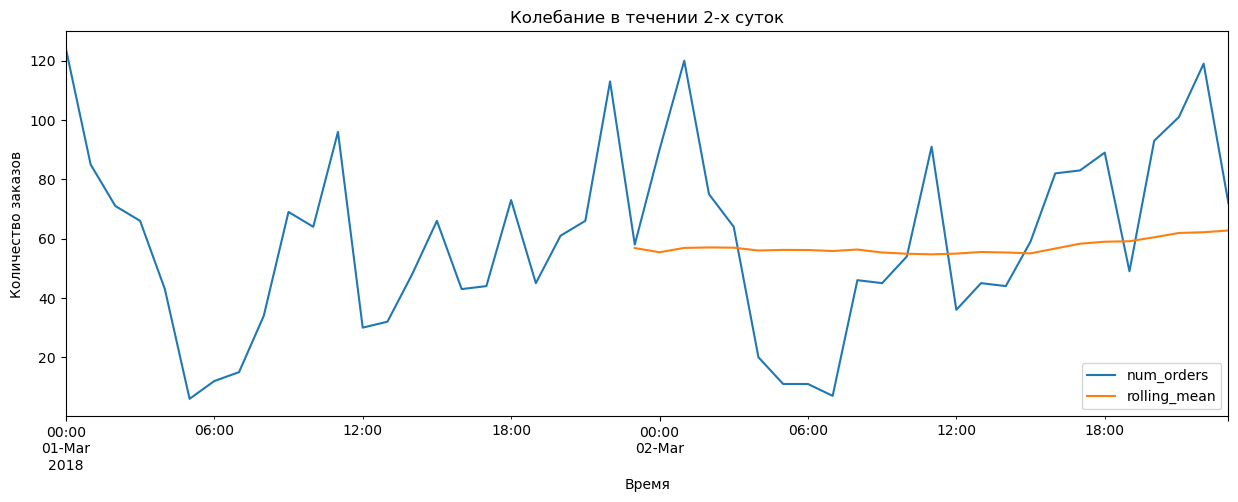

<Figure size 1500x500 with 0 Axes>

In [23]:
# Колебание количества заказов в тичение суток
df['2018-03-01':'2018-03-02'].plot()
plt.title('Колебание в течении 2-х суток')
plt.xlabel("Время")
plt.ylabel("Количество заказов")
plt.figure();

Падение количсетва заказов с 00 часов до 6 утра, бурный рост к обеду, потом опять затухание до конца рабочего дня и опять рост до конца дня.

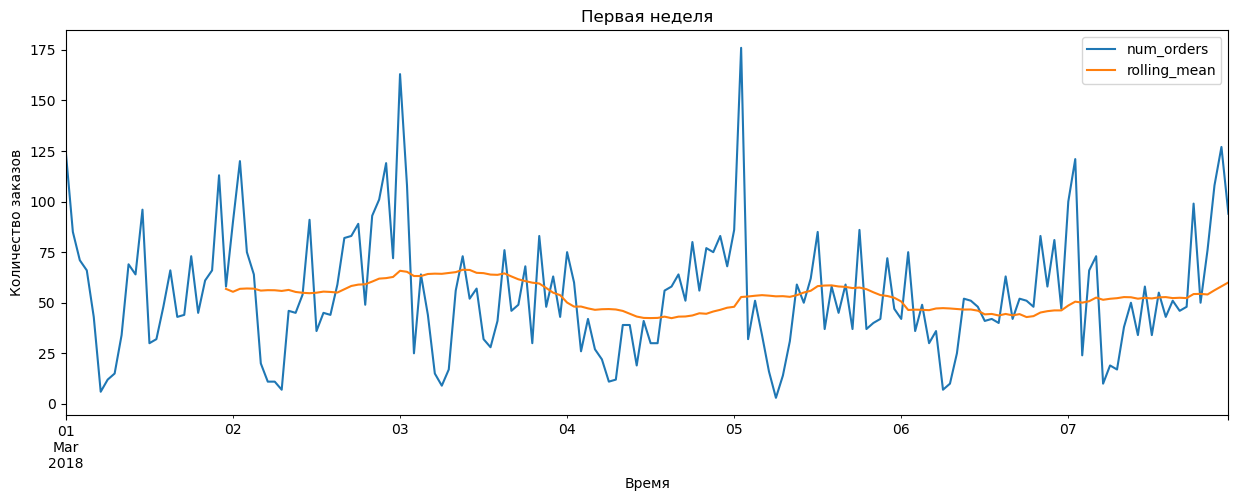

<Figure size 1500x500 with 0 Axes>

In [24]:
# Первая неделя исследуемого ДатаФрейма
df['2018-03-01':'2018-03-07'].plot()
plt.title('Первая неделя')
plt.xlabel("Время")
plt.ylabel("Количество заказов")
plt.figure();

Первая неделя исследуемого периода показывает, среднее количество заказов в районе 60.

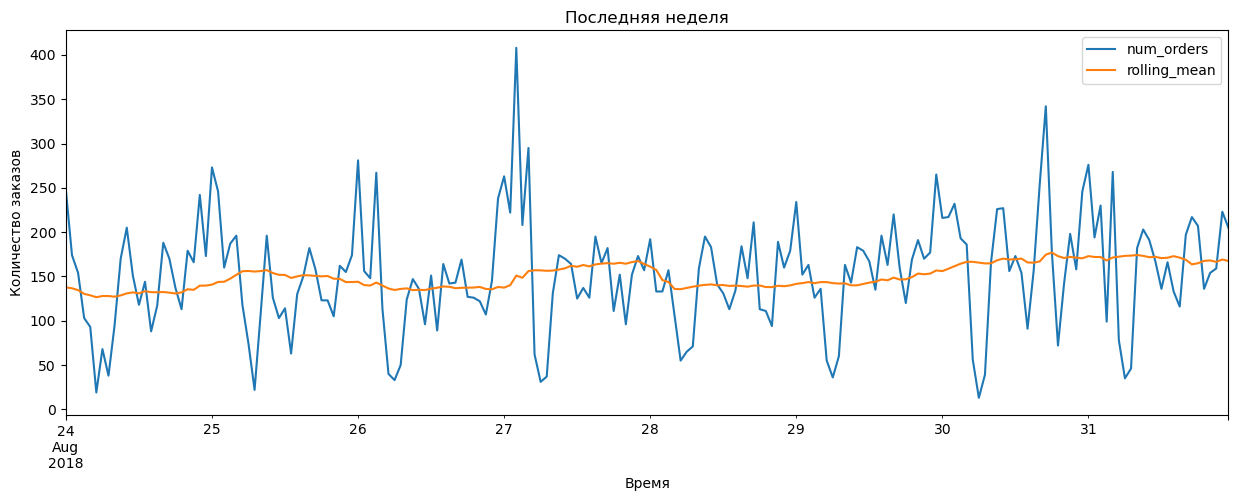

<Figure size 1500x500 with 0 Axes>

In [25]:
# Последняя неделя исследуемого ДатаФрейма
df['2018-08-24':'2018-08-31'].plot()
plt.title('Последняя неделя')
plt.xlabel("Время")
plt.ylabel("Количество заказов")
plt.figure();

Последняя неделя исследуемого периода показывает рост почти в 3 раза среднего количества заказов до 150-160.

In [26]:
# Удалим столбец, преед подготовкой к обучению
df.drop('rolling_mean', axis=1)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


### Выводы по результатам анализа:
<p>Если предположить, что данные о заказах взяты из Российского рынка. То в 2018 году сервис Яндекс Такси увеличил свою вырочку почти в 4 раз. Также примерно в этом году произошло снижение тарифа на посадку и усиление конкуренции между агрегаторами. Кроме того, в этом году был большой поток туристов из-за ЧМ мира по футболу. По итогам года все агрегаторы такси увеличили свою вырочку.</p>
<p>Учитывая среднее первой и последний недели с марта по август, виден рост среднего количества заказов пости в 3 раза.</p>
<p>Сезонность показывает колебания количества заказов в течение исследуемого промежутка времени.т.е. суточные колебания количества заказов. Падение количсетва заказов с 00 часов до 6 утра, бурный рост к обеду, потом опять затухание до конца рабочего дня и опять рост до конца дня.</p>


## Обучение

In [27]:
# Функция по созданию признаков
def make_features(data, max_lag, rolling_mean_size):
    #data['year'] = data.index.year
    #data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data.iloc[:,0].shift(lag)

    data['rolling_mean'] = data.iloc[:,0].shift().rolling(rolling_mean_size).mean()

In [28]:
# Преобразуем Дата Фрейм с помощью функции
make_features(df, 168, 24)

C:\Users\ipd08\AppData\Local\Temp\ipykernel_25232\2207248400.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['lag_{}'.format(lag)] = data.iloc[:,0].shift(lag)
C:\Users\ipd08\AppData\Local\Temp\ipykernel_25232\2207248400.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['lag_{}'.format(lag)] = data.iloc[:,0].shift(lag)
C:\Users\ipd08\AppData\Local\Temp\ipykernel_25232\2207248400.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

In [29]:
# Провери работу 
df.head(10)

,num_orders,rolling_mean,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_159,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,1,3,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,1,3,1,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,1,3,2,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,NaN,1,3,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,NaN,1,3,4,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,NaN,1,3,5,43.0,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 06:00:00,12,NaN,1,3,6,6.0,43.0,66.0,71.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 07:00:00,15,NaN,1,3,7,12.0,6.0,43.0,66.0,71.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 08:00:00,34,NaN,1,3,8,15.0,12.0,6.0,43.0,66.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
# Раздели на выборки преобразованный Дата Фрейм согласно задания определив для тестовой части 10 %
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

### Линейна регрессия

In [33]:
%time
# Обучим модель с помощью кросвалидации и найдем лучшие гиперпараметры
param_search = [{'fit_intercept': [True, False]},
                
                {'copy_X':[True, False]}
             ]
model_lr = LinearRegression()
tscv = TimeSeriesSplit(n_splits=10)
gsearch = GridSearchCV(estimator=model_lr, cv=tscv, param_grid=param_search)
gsearch.fit(features_train, target_train)

CPU times: total: 0 ns
Wall time: 0 ns


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=LinearRegression(),
             param_grid=[{'fit_intercept': [True, False]},
                         {'copy_X': [True, False]}])

In [34]:
gsearch.best_params_

{'fit_intercept': False}

In [35]:
%%time
# Выберем параметры
parametrs = { 'n_estimators': range (10, 91, 10),
              'max_depth': range (1,5, 2), 
             'min_samples_leaf': range (1,8),
             'min_samples_split': range (2,10,2) }
# Обучи модель и осуществим поиск личших
rfr = RandomForestRegressor()
tscv = TimeSeriesSplit(n_splits=10)
grid = GridSearchCV(rfr, parametrs, cv=tscv, n_jobs=-1, verbose=10, scoring='neg_mean_squared_error')
grid.fit(features_train, target_train)



Fitting 10 folds for each of 504 candidates, totalling 5040 fits
CPU times: total: 18 s
Wall time: 8min 43s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': range(1, 5, 2),
                         'min_samples_leaf': range(1, 8),
                         'min_samples_split': range(2, 10, 2),
                         'n_estimators': range(10, 91, 10)},
             scoring='neg_mean_squared_error', verbose=10)

In [36]:
# ЛУчшие гиперпараметры
grid.best_params_

{'max_depth': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 70}

### Модель CatBoost

In [37]:
%time
cat_features = ['hour', 'day', 'dayofweek']
# Построим модель CatBoostRegressor

model_cat = CatBoostRegressor(loss_function="RMSE", verbose=10) 

grid = {'learning_rate': [0.03, 0.1,  0.3, 0.4, 0.9],
        'depth': [4, 6, 10,],
        'l2_leaf_reg': [1, 3, 5, 7],
        'iterations': [100, 200] }
tscv = TimeSeriesSplit(n_splits=10)
grid_search_result = model_cat.grid_search(grid,
                                       X=features_train,
                                       y=target_train,
                                       plot=True, cv=tscv)

CPU times: total: 0 ns
Wall time: 0 ns


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 78.1153050	test: 112.8107058	best: 112.8107058 (0)	total: 141ms	remaining: 13.9s
10:	learn: 60.6587349	test: 92.3224480	best: 92.3224480 (10)	total: 164ms	remaining: 1.33s
20:	learn: 47.8552174	test: 76.5185385	best: 76.5185385 (20)	total: 191ms	remaining: 718ms
30:	learn: 38.7173609	test: 64.5961618	best: 64.5961618 (30)	total: 218ms	remaining: 486ms
40:	learn: 32.3366325	test: 55.9524907	best: 55.9524907 (40)	total: 249ms	remaining: 358ms
50:	learn: 27.8851023	test: 49.0624504	best: 49.0624504 (50)	total: 280ms	remaining: 269ms
60:	learn: 24.8708246	test: 43.9268565	best: 43.9268565 (60)	total: 313ms	remaining: 200ms
70:	learn: 22.9489785	test: 40.2098672	best: 40.2098672 (70)	total: 349ms	remaining: 143ms
80:	learn: 21.6541471	test: 37.4339525	best: 37.4339525 (80)	total: 376ms	remaining: 88.1ms
90:	learn: 20.8055552	test: 35.3483150	best: 35.3483150 (90)	total: 402ms	remaining: 39.7ms
99:	learn: 20.2781843	test: 33.9134462	best: 33.9134462 (99)	total: 428ms	remaining: 0us

Лучшие гиперпараметры:
- learning_rate : 0.3,
- depth: 4,
- l2_leaf_reg: 3,
- iterations: 200

### Выводы по результатам обучения моделей:
Быстрее всего нашли параметры для Линейной регрессии, бустинг - Cat Boost и Случайный лес долго работали.

## Тестирование

In [39]:
%time
# Посмотрим на результат предсказания на тестовой выборке
predict_test = gsearch.predict(features_test)

print("RMSE Линейной регрессии тестовой выборки:",  mean_squared_error(target_test, predict_test)**0.5)

CPU times: total: 0 ns
Wall time: 0 ns
RMSE Линейной регрессии тестовой выборки: 34.47981361237306


In [40]:
%%time
# Построим предсказание CatBoost на тестовой выборке 
probabilities_test = model_cat.predict(features_test)
rmse_CatBoostRegressor = mean_squared_error(target_test, probabilities_test)**0.5
print("RMSE модели CatBoostRegressor", rmse_CatBoostRegressor)

RMSE модели CatBoostRegressor 37.54849410966582
CPU times: total: 469 ms
Wall time: 28.8 ms


In [41]:
%%time
# Работа модели Случайного леса - GridSearchCV на тесте 

# Выберем параметры
parametrs = { 'n_estimators': [30],
              'max_depth': [3], 
             'min_samples_leaf': [7],
             'min_samples_split': [2] }
# Обучи модель и осуществим поиск личших
rfr = RandomForestRegressor()
tscv = TimeSeriesSplit(n_splits=10)
grid = GridSearchCV(rfr, parametrs, cv=tscv, n_jobs=-1, verbose=10, scoring='neg_mean_squared_error')
grid.fit(features_train, target_train)
# Предсказания
predictions = grid.best_estimator_.predict(features_test)
# Результат
rmse_les = mean_squared_error(target_test, predictions)**0.5
print("RMSE модели Случайный лес на тестовой выборке", rmse_les)


Fitting 10 folds for each of 1 candidates, totalling 10 fits
RMSE модели Случайный лес на тестовой выборке 47.50987496196877
CPU times: total: 156 ms
Wall time: 4.41 s


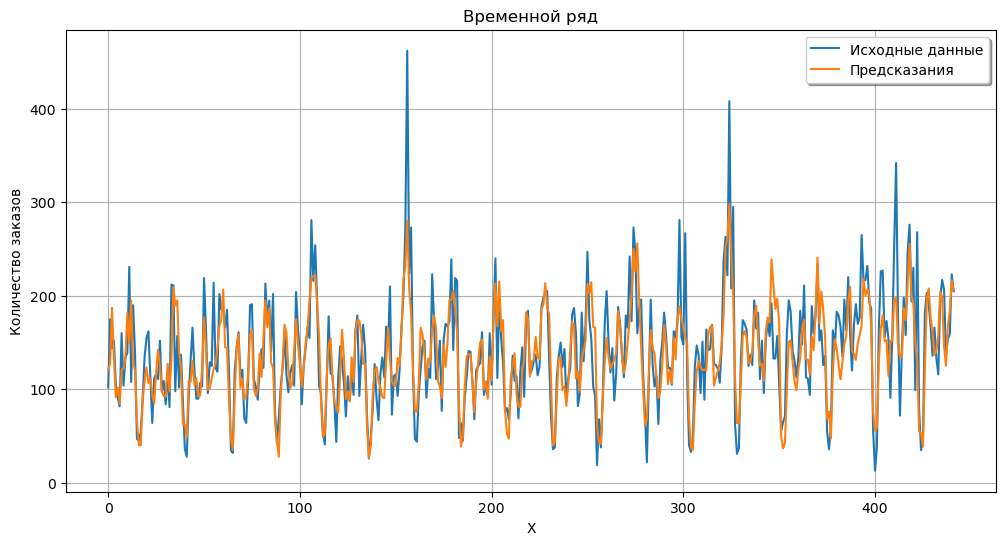

In [42]:
# Визуализаця предсказаний и ответов Линейной регрессии
x_ax = range(len(target_test))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, target_test, label="Исходные данные")
plt.plot(x_ax,predict_test, label="Предсказания")
plt.title("Временной ряд")
plt.xlabel('X')
plt.ylabel('Количество заказов')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()  


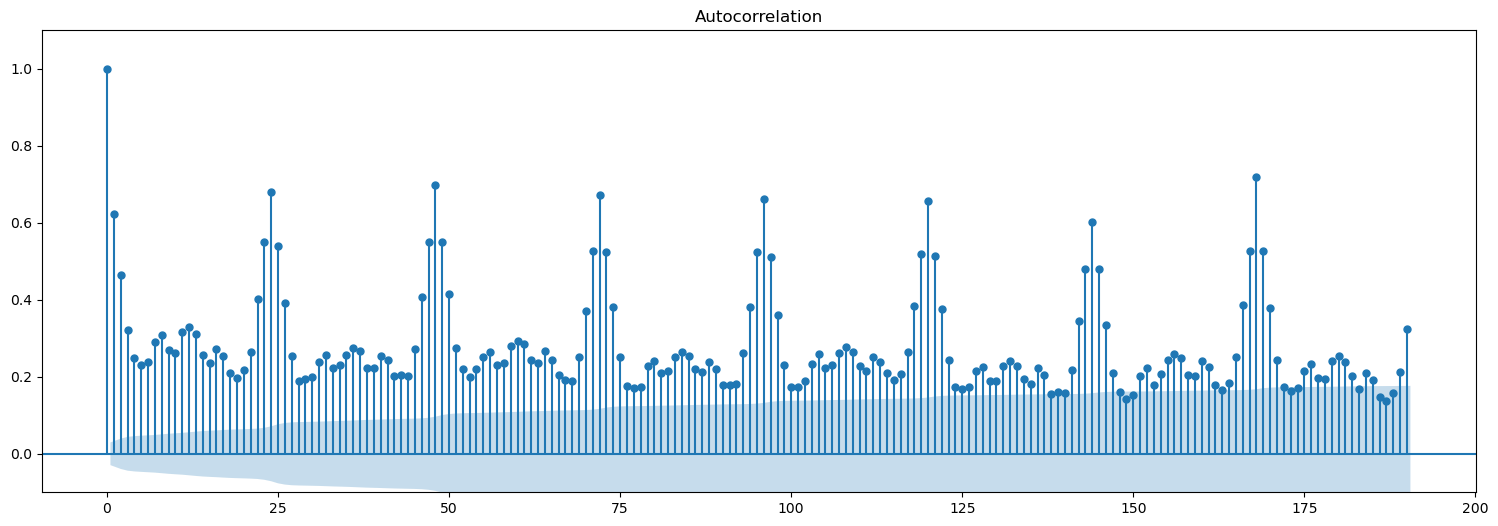

In [43]:
import matplotlib.pyplot as plt

# Автокорреляцией уровней временного ряда
from statsmodels.graphics import tsaplots

fig = tsaplots.plot_acf(df['num_orders'],lags= 190)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show() 



### Выводы по итогам тестирования:
Показатели моделей:

| Модель | Показатель RMSE |
| --- | --- |
| Линейная регрессия |  34.47|
| Случайный лес |  47.46|
| CatBoost Regressor | 37.54|


<div style="border:solid Chocolate 2px; padding: 40px">
<h2>Итоговый вывод:</h2>
<p>Если предположить, что данные о заказах взяты из Российского рынка. То в 2018 году сервис Яндекс Такси увеличил свою вырочку почти в 4 раз. Также примерно в этом году произошло снижение тарифа на посадку и усиление конкуренции между агрегаторами. Кроме того, в этом году был большой поток туристов из-за ЧМ мира по футболу. По итогам года все агрегаторы такси увеличили свою вырочку.</p>
<p>Учитывая среднее первой и последний недели с марта по август, виден рост среднего количества заказов почти в 3 раза.</p>
<p>Сезонность показывает колебания количества заказов в течение исследуемого промежутка времени т.е. суточные колебания количества заказов. Падение количсетва заказов с 00 часов до 6 утра, бурный рост к обеду, потом опять затухание до конца рабочего дня и опять рост до конца суток.</p>
Показатели моделей:

Показатели моделей:

| Модель | Показатель RMSE |
| --- | --- |
| Линейная регрессия |  34.47|
| Случайный лес |  47.46|
| CatBoost Regressor | 37.54|


Модель Линейная регрессии показала лучшие результаты по скорости и качеству, что для меня стало открытием.